In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Sign_verif/Sign_Verif')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/sign/Sign_Verif/dataset',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 1416 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/sign/Sign_Verif/dataset',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)


Found 352 images belonging to 2 classes.


100%|██████████| 5/5 [04:08<00:00, 49.64s/it]


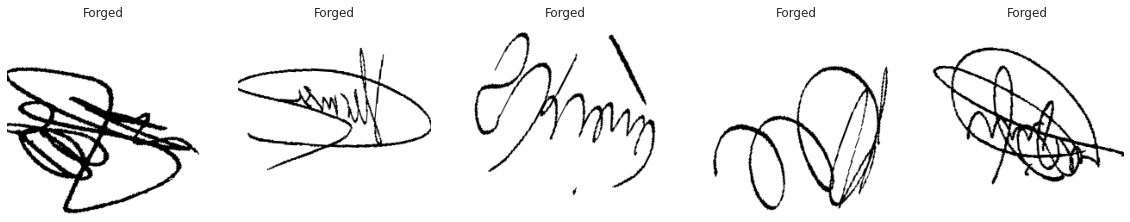

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Original')
    elif a[1] == 1:
        ax[i].set_title('Forged')
  

In [ ]:

base_model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [ ]:

METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
12/12 [==============================] - 25s 2s/step - loss: 0.3496 - auc: 0.9292 - val_loss: 0.9329 - val_auc: 0.6450

Epoch 00001: val_auc did not improve from 0.77222
Epoch 2/10
12/12 [==============================] - 24s 2s/step - loss: 0.3339 - auc: 0.9348 - val_loss: 1.0656 - val_auc: 0.6079

Epoch 00002: val_auc did not improve from 0.77222
Epoch 3/10
12/12 [==============================] - 24s 2s/step - loss: 0.3597 - auc: 0.9258 - val_loss: 1.0843 - val_auc: 0.6160

Epoch 00003: val_auc did not improve from 0.77222
Epoch 4/10
12/12 [==============================] - 24s 2s/step - loss: 0.3572 - auc: 0.9249 - val_loss: 0.9965 - val_auc: 0.6191

Epoch 00004: val_auc did not improve from 0.77222
Epoch 5/10
12/12 [==============================] - 24s 2s/step - loss: 0.3474 - auc: 0.9293 - val_loss: 1.1075 - val_auc: 0.6007

Epoch 00005: val_auc did not improve from 0.77222
Epoch 6/10
12/12 [==============================] - 24s 2s/step - loss: 0.3326 - auc: 0.9348 - 